In [3]:
"""
@Author: blankxiao
@file: A_2.py
@Created: 2024-09-06 14:03
@Desc: A_2 求出碰撞时间 和当时各个部分的状态(位置和速度)
主要是求碰撞时间 然后代入A_1模型 得出碰撞后各个部分的位置和速度
"""

import pandas as pd
import numpy as np
import sympy as sp

from A_1 import get_alpha_0, get_r_0, get_x_y, get_r_i, get_v_i, get_alpha_i, loong_head_speed


def get_pos_of_corner(alpha_i: int, alpha_i_pre: int, r_i: int, r_i_pre: int, r_0: int, r_1: int, alpha_0: int, alpha_1: int):
    """
    获取三个点的坐标
    """

    # 孔距边界距离 m
    AD_d = 0.275
    # 板凳长度的一半
    CD_d = 0.15
    # A C的距离
    AC_d = sp.sqrt(AD_d ** 2 + CD_d ** 2)

    # 龙头两个把手的间距
    L_loong_head = 3.41 - 2 * AD_d
    # 龙身两个把手的间距
    L_loong_body = 2.20 - 2 * AD_d
    # 龙头两个把手的间距
    D_1 = L_loong_head
    # 龙身两个把手的间距
    D_2 = L_loong_body

    Gama = sp.atan(CD_d / AD_d)

    gama_i_2 = - Gama + alpha_i_pre - alpha_i + sp.asin(r_i / D_2 * sp.sin(alpha_i_pre - alpha_i))
    gama_i_1 = - Gama + alpha_i_pre - alpha_i + sp.asin(r_i_pre / D_2 * sp.sin(alpha_i_pre - alpha_i))
    gama_0 = Gama + alpha_0 - alpha_1 + sp.asin(r_1 / D_1 * sp.sin(alpha_0 - alpha_1))

    r_B_i = sp.sqrt(AC_d ** 2 + r_i ** 2 - 2 * AC_d * r_i * sp.cos(gama_i_1))
    r_B_i_pre = sp.sqrt(AC_d ** 2 + r_i_pre ** 2 - 2 * AC_d * r_i_pre * sp.cos(gama_i_2) )
    r_C_0 = sp.sqrt(AC_d ** 2 + r_0 ** 2 - 2 * AC_d * r_0 * sp.cos(gama_0) )

    beta_B_i = alpha_i_pre + sp.asin(AC_d / r_B_i * sp.sin(gama_i_1))
    beta_B_i_pre = alpha_i - sp.asin(AC_d / r_B_i_pre * sp.sin(gama_i_2))
    beta_C_0 = alpha_0 + sp.asin(AC_d / r_0 * sp.sin(gama_0))

    x_B_i, y_B_i = get_x_y(alpha=beta_B_i, r=r_B_i)
    x_B_i_pre, y_B_i_pre = get_x_y(alpha=beta_B_i_pre, r=r_B_i_pre)
    x_C_0, y_C_0 = get_x_y(alpha=beta_C_0, r=r_C_0)

    return (x_B_i, y_B_i), (x_B_i_pre, y_B_i_pre), (x_C_0, y_C_0)

def get_end_time():
    """
    获取龙头到达原点的时间 并将位置信息存入df_rav
    """
    t = sp.var("t")

    # 将 get_alpha_0 代入 get_r_0，得到关于 t 的函数
    alpha_0 = get_alpha_0(t)
    r_0 = get_r_0(alpha_0)
    # 求解方程 r_0 = 0
    equation = sp.Eq(r_0, 0)
    return float(sp.solve(equation, t)[0])


def forward_vaild(r_0: int, r_1: int, spiral_d: int):
    """
    @param r_0: 龙头极径
    @param r_1: 第一节龙身极径
    返回是否是锐角
    """
    theta_0 = 2 * np.pi * r_0 / spiral_d
    theta_1 = 2 * np.pi * r_1 / spiral_d

    detal_x = (r_0 * sp.cos(theta_0) - r_1 * sp.cos(theta_1))
    dx = sp.cos(theta_0 - theta_0 * sp.sin(theta_0))
    detal_y = r_0 * sp.sin(theta_0) - r_1 * sp.sin(theta_1)
    dy = sp.sin(theta_0 + theta_0 * sp.cos(theta_0))
    return  detal_x * dx + detal_y * dy >= 0


def are_collinear(A, B, C, atol=0.05):
    """
    判断三个极坐标点 A、B、C 是否共线
    :param A: 点 A 的直角坐标
    :param B: 点 B 的直角坐标
    :param C: 点 C 的直角坐标
    :return: 如果 A、B、C 共线，返回 True
    """
    # 将极坐标转换为笛卡尔坐标
    x_A, y_A = [A[0], A[1]]
    x_B, y_B = [B[0], B[1]]
    x_C, y_C = (C[0], C[1])
    
    # 计算向量 AB 和 AC
    vector_AB = (x_B - x_A, y_B - y_A)
    vector_AC = (x_C - x_A, y_C - y_A)
    
    # 计算向量 AB 和 AC 的叉积
    cross_product = vector_AB[0] * vector_AC[1] - vector_AB[1] * vector_AC[0]
    # 共线 且 A在BC之间
    if cross_product < 0.05 and (x_A - x_B) * (x_A - x_C) <= 2:
        print(cross_product, (x_A - x_B) * (x_A - x_C))
    return np.isclose(cross_product, 0, atol=atol) and np.isclose((x_A - x_B) * (x_A - x_C), 0, atol=atol * 5)




In [4]:


num_point = 15
end = get_end_time()
print("到达零点时间", end)
# 认为碰撞仅存在2-10 这些点
time_range = np.arange(end - 80, end - 30, 0.05).tolist()

df_rav = pd.DataFrame(index=pd.MultiIndex.from_product([range(num_point), ['r', 'alpha', "v"]]), columns=time_range)

df_xyv = pd.DataFrame(index=pd.MultiIndex.from_product([range(num_point), ['x', 'y', "v"]]), columns=time_range)

df_coner = pd.DataFrame(index=pd.MultiIndex.from_product([range(num_point), ['B_i', 'B_i_pre', "C_0"]]), columns=time_range)

crash_t = 0
crash = False
crash_list = []

for t in time_range:
    for point_index in range(num_point):
        if point_index != 0:
            r_i_pre=df_rav[t][point_index - 1, 'r']
            v_i_pre=df_rav[t][point_index - 1, 'v']

            cur_r = get_r_i(r_i_pre=r_i_pre, point_index=point_index)
            cur_alpha = get_alpha_i(r_i=cur_r)

            cur_v = get_v_i(v_i_pre=v_i_pre, r_i_pre=r_i_pre, r_i=cur_r)
        else:
            cur_alpha = get_alpha_0(t)
            cur_r = get_r_0(cur_alpha)
            cur_v = loong_head_speed

        cur_x, cur_y = get_x_y(alpha=cur_alpha, r=cur_r)
        
        # 记录当前的 r 和 alpha
        df_rav.at[(point_index, 'r'), t] = cur_r
        df_rav.at[(point_index, 'alpha'), t] = cur_alpha
        df_rav.at[(point_index, 'v'), t] = cur_v

        df_xyv.at[(point_index, 'x'), t] = cur_x
        df_xyv.at[(point_index, 'y'), t] = cur_y
        df_xyv.at[(point_index, 'v'), t] = cur_v
        
        if point_index > 2:
            alpha_0 = df_rav.at[(0, 'alpha'), t]
            r_0 = df_rav.at[(0, 'r'), t]

            alpha_1 = df_rav.at[(1, 'alpha'), t]
            r_1 = df_rav.at[(1, 'r'), t]

            alpha_i_pre = df_rav.at[(point_index - 1, 'alpha'), t]
            r_i_pre = df_rav.at[(point_index - 1, 'r'), t]

            B_i, B_i_pre, C_0 = get_pos_of_corner(alpha_0=alpha_0, r_0=r_0, alpha_1=alpha_1, r_1=r_1, alpha_i_pre=alpha_i_pre, r_i_pre=r_i_pre, alpha_i=cur_alpha, r_i=cur_r )
            df_coner.at[(point_index, 'B_i'), t] = B_i
            df_coner.at[(point_index, 'B_i_pre'), t] = B_i_pre
            df_coner.at[(point_index, 'C_0'), t] = C_0
            if are_collinear(B_i, B_i_pre, C_0):
                print(f'{t}时刻发现碰撞点 r_0为{r_0}')
                crash_list.append(t)
    # if forward_vaild(r_0=df_rav[t][0, 'r'], r_1=df_rav[t][1, 'r'], spiral_d=0.55):
    #     print(f'{t}时刻 r_0 r_1为 锐角')
    #     crash = True
    #     break




到达零点时间 442.3362456254434
0.0493597295321280 1.03788013140307
0.0476882850868792 0.986757151946217
0.0460750201750211 0.936743650594865
0.0445201201655336 0.887869340767384
0.0430237706379908 0.840162346533489
0.0415861573795391 0.793649180299156
0.0402074663821896 0.748354722528009
0.0388878838397151 0.704302203519482
0.0376275961447401 0.661513187263154
0.0364267898860400 0.620007557385945
0.0352856518449718 0.579803505204721
0.0342043689930169 0.540917519897297
0.0331831284880497 0.503364380798618
0.0322221176716897 0.467157151830338
0.0313215240658635 0.432307178065612
0.0304815353694535 0.398824084430906
0.0297023394553799 0.366715776542884
0.0289841243668322 0.335988443676075
0.0283270783142406 0.306646563854369
0.0277313896717469 0.278692911056838
0.0271972469736891 0.252128564525513
0.0267248389111748 0.226952920160593
398.0862456254515时刻发现碰撞点 r_0为2.78331939507425
0.0263143543283859 0.203163703985509
398.1362456254515时刻发现碰撞点 r_0为2.78174645378159
0.0259659822193122 0.180756987661

In [10]:
df_xy_dropna = df_xyv[crash_list]
df_crash = df_coner[crash_list].dropna()
# print(time_range)
# print(len(time_range))
print(crash_list)
crash_t = crash_list[0]

[398.0862456254515, 398.1362456254515, 398.18624562545153, 398.23624562545155, 398.28624562545156, 398.33624562545157, 398.3862456254516, 398.4362456254516, 398.4862456254516, 398.5362456254516, 398.5862456254516, 398.63624562545164, 398.68624562545165, 398.73624562545166, 398.78624562545167, 398.8362456254517, 398.8862456254517, 398.9362456254517, 398.9862456254517, 399.0362456254517, 399.08624562545174, 399.13624562545175, 399.18624562545176, 399.2362456254518, 399.2862456254518, 399.3362456254518, 399.3862456254518, 399.4362456254518, 399.48624562545183, 399.53624562545184, 399.58624562545185, 399.63624562545186, 399.6862456254519, 399.7362456254519, 399.7862456254519, 406.4362456254534, 406.4862456254534, 406.53624562545343, 406.58624562545344, 406.63624562545345, 406.68624562545347, 406.7362456254535, 406.7862456254535, 406.8362456254535, 406.8862456254535, 406.9362456254535, 406.98624562545353, 407.03624562545355, 407.08624562545356, 407.13624562545357, 407.1862456254536, 407.236

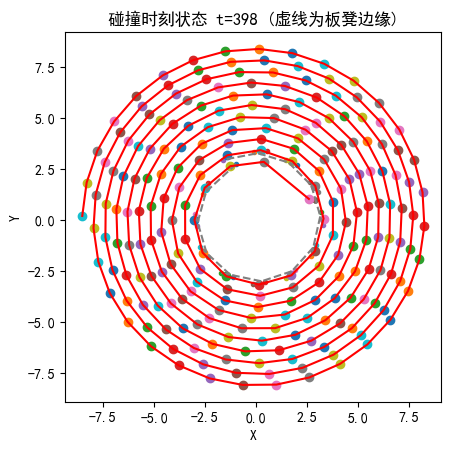

In [46]:
import matplotlib.pyplot as plt

df_crash = df_coner[crash_t].dropna()
df_xy_dropna = df_xyv[crash_t].dropna()
# print(df_crash)


# 创建图形
fig, ax = plt.subplots()

# 可视化coner
for index, group in df_crash.groupby(level=0):
    # 获取 B_i 和 B_i_pre 的坐标
    B_i = group.loc[index, 'B_i']
    B_i_pre = group.loc[index, 'B_i_pre']
    C_0 = group.loc[index, 'C_0']
    
    ax.scatter(B_i[0], B_i[1], marker='.')
    ax.scatter(B_i_pre[0], B_i_pre[1], marker='.')
    ax.scatter(C_0[0], C_0[1], marker='.')
    
    ax.plot([B_i[0], B_i_pre[0]], [B_i[1], B_i_pre[1]], linestyle='--', color='gray')

x_list = []
y_list = []

for index, group in df_xy_dropna.groupby(level=0):
    # 获取 B_i 和 B_i_pre 的坐标
    x = group.loc[index, 'x']
    y = group.loc[index, 'y']
    
    ax.scatter(x, y)
    x_list.append(x)
    y_list.append(y)
ax.plot(x_list, y_list, linestyle='-', color='red')


# 设置图形属性
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'碰撞时刻状态 t={round(crash_t)} (虚线为板凳边缘)')
ax.set_aspect('equal')

# # 显示图形
plt.show()

In [41]:
import pandas as pd

from A_1 import get_r_i, get_alpha_i, get_alpha_0, get_r_0, get_v_i, get_x_y

crash_t = crash_list[0]
num_point = 224

df_position = pd.DataFrame(index=[
    ['龙头'] + 
    [f'第{i}节龙身' for i in range(1, 224 - 2)] +
    ['龙尾'] +
    ['龙尾（后）']
],
columns=["横坐标x (m)", "纵坐标y (m)", "速度 (m/s)"])

df_rav = pd.DataFrame(index=pd.MultiIndex.from_product([range(num_point), ['r', 'alpha', "v"]]), columns=[crash_t])


df_rav = pd.DataFrame(index=pd.MultiIndex.from_product([range(num_point), ['r', 'alpha', "v"]]), columns=[crash_t])

for point_index in range(num_point):
        if point_index != 0:
            r_i_pre = df_rav[crash_t][point_index - 1, 'r']
            v_i_pre = df_rav[crash_t][point_index - 1, 'v']
            cur_r = get_r_i(r_i_pre=r_i_pre, point_index=point_index)
            cur_alpha = get_alpha_i(r_i=cur_r)
            cur_v = get_v_i(v_i_pre=v_i_pre, r_i_pre=r_i_pre, r_i=cur_r)

        else:
            cur_alpha = get_alpha_0(crash_t)
            cur_r = get_r_0(cur_alpha)
            cur_v = 1

        df_rav.at[(point_index, 'r'), crash_t] = cur_r
        df_rav.at[(point_index, 'alpha'), crash_t] = cur_alpha
        df_rav.at[(point_index, 'v'), crash_t] = cur_v

        cur_x, cur_y = get_x_y(alpha=cur_alpha, r=cur_r)

        df_xyv.at[(point_index, 'x'), crash_t] = cur_x
        df_xyv.at[(point_index, 'y'), crash_t] = cur_y
        df_xyv.at[(point_index, 'v'), crash_t] = cur_v


        index = df_position.index[point_index]
        df_position.loc[index, "横坐标x (m)"] = round(cur_x, 6)
        df_position.loc[index, "纵坐标y (m)"] = round(cur_y, 6)
        df_position.loc[index, "速度 (m/s)"] = round(cur_v, 6)

print(df_position)

          横坐标x (m)  纵坐标y (m)  速度 (m/s)
龙头        2.584109  1.034044         1
第1节龙身     0.375742  2.851381  0.996576
第2节龙身    -1.260788  2.640975  0.996094
第3节龙身    -2.523054  1.578345  0.995646
第4节龙身    -3.024805  0.006484  0.995227
...            ...       ...       ...
第219节龙身  -5.877213  6.077967  0.984533
第220节龙身  -6.958818  4.831922  0.984526
第221节龙身  -7.778366  3.399846  0.984520
龙尾       -8.305380  1.836274  0.984514
龙尾（后）    -8.520586  0.200369  0.984508

[224 rows x 3 columns]


In [22]:
df_position.to_excel('result2.xlsx')

In [42]:

x_list = df_xyv[crash_t][:, 'x']
y_list = df_xyv[crash_t][:, 'y']
v_list = df_xyv[crash_t][:, 'v']
print(x_list)
print(y_list)
print(v_list)

0       2.58410915760139
1      0.375741845273263
2      -1.26078779164336
3      -2.52305444753474
4      -3.02480541308796
             ...        
219    -5.87721256977308
220    -6.95881836606055
221    -7.77836599909300
222    -8.30537973014832
223    -8.52058632817398
Name: 398.0862456254515, Length: 224, dtype: object
0         1.03404386589599
1         2.85138087752610
2         2.64097472862947
3         1.57834455334514
4      0.00648388249470110
              ...         
219       6.07796685332298
220       4.83192154859389
221       3.39984554600498
222       1.83627382482333
223      0.200368534115339
Name: 398.0862456254515, Length: 224, dtype: object
0                      1
1      0.996576089277727
2      0.996094192846114
3      0.995645591761450
4      0.995226936801057
             ...        
219    0.984532622567853
220    0.984526491907932
221    0.984520410732735
222    0.984514378445230
223    0.984508394457956
Name: 398.0862456254515, Length: 224, dtype: obje

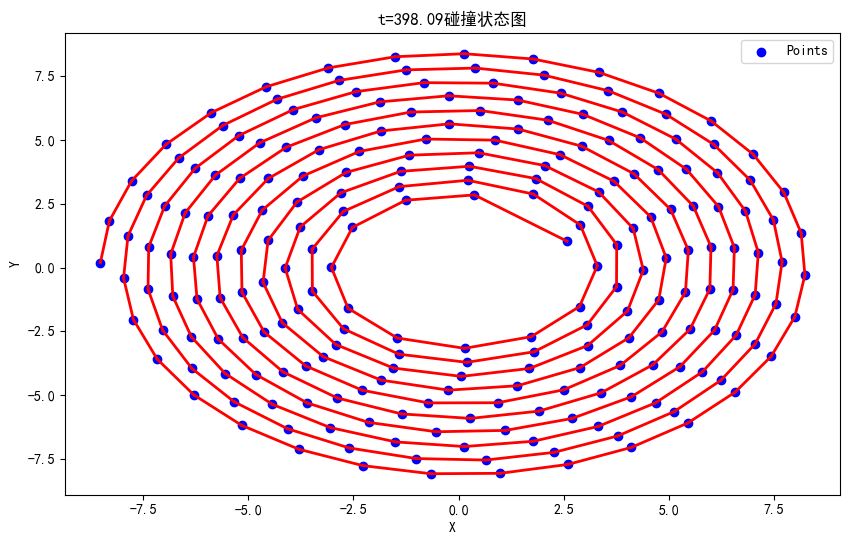

In [45]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False    # 显示负号
# 设置绘图参数
color = 'blue'
marker = 'o'
s = 30
alpha = 0.8
line_color = 'red'
line_width = 1
spiral_color = 'green'
spiral_width = 1
time_range = [crash_t]

x_list = df_xyv[crash_t][:, 'x']
y_list = df_xyv[crash_t][:, 'y']


def plot_points_with_lines(x, y, title):
    """
    绘制散点图并将相邻的点连起来
    :param x: x 坐标的列表
    :param y: y 坐标的列表
    """
    # 创建图形
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 绘制散点图
    ax.scatter(x, y, color='blue', label='Points')
    
    # 将相邻的点连起来
    for i in range(len(x) - 1):
        ax.plot([x[i], x[i + 1]], [y[i], y[i + 1]], color='red', linestyle='-', linewidth=2)
    
    # 设置图形属性
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    
    # 显示图形
    plt.show()
plot_points_with_lines(x_list, y_list, f"t={round(crash_t, 2)}碰撞状态图")
